In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import air_traff_utils as atu
import geopandas as gpd

import ipdb

In [2]:
atu.setup_seed(12)

# Loading Data

In [186]:
us_CSA = gpd.read_file('./data/us_CSA.shp')
OD = pd.read_csv('./outputs/201904_OD_CSA.csv', index_col=0).sort_index(axis=0).sort_index(axis=1)

In [187]:
us_CSA_use = us_CSA.loc[us_CSA['if_plot']==1]
print(us_CSA_use.shape)
us_CSA_use.head(2)

(24, 26)


,TotPop,CSA,CBSA,CBSA_Name,AutoOwn0,AutoOwn1,AutoOwn2p,TotEmp,E_LowWageW,E_MedWageW,...,D4C,D4D,D5AR,D5AE,NatWalkInd,INTPTLAT,INTPTLON,CSA_Name,if_plot,geometry
8,6584708,122.0,29300.0,"LaGrange, GA-AL",142257,759558,1449909,2970375,668868,969644,...,-60276.863137,-60268.179268,310871248,224466891,8.498581,33.834001,-84.305803,"Atlanta--Athens-Clarke County--Sandy Springs, ...",1,"POLYGON ((-85.16585 32.80850, -85.16563 32.808..."
9,4727034,429.0,38060.0,"Phoenix-Mesa-Chandler, AZ",100799,609540,969422,2019049,428811,720918,...,-33643.860240,-33629.285213,262427439,204143835,10.838547,33.462312,-111.985821,"Phoenix-Mesa, AZ",1,"POLYGON ((-112.20470 32.50672, -112.20791 32.5..."


(24, 24)


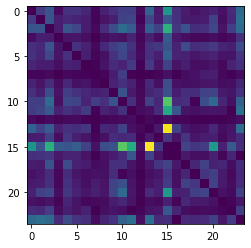

In [188]:
print(OD.shape)
plt.imshow(OD)

# Prepare Feature Pairs
### Each two OD pair has its feature combination, [feature of loc1, feature of loc2, distance]

# Define VAE Model Structure

In [189]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
from torchinfo import summary
from torch.utils.data import TensorDataset

In [190]:
# Model specification
class VAE_FC_Net(nn.Module):
    def __init__(self, OD_size, feature_dim=18+18+1, dropout_p=0.35):
        super(VAE_FC_Net, self).__init__()
        self.OD_size = OD_size
        self.feature_dim = feature_dim
        self.dropout_p = dropout_p
        
        self.encoder = nn.Sequential(
            nn.Linear(OD_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, feature_dim*2),
            # feature_dim is multiplied by 2 becasue there are mean and variance
            nn.ReLU(),
            nn.Dropout(dropout_p)
        )
        
        self.decoder = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, 256),
            nn.ReLU(),
            nn.Dropout(dropout_p),
            
            nn.Linear(256, OD_size),
            nn.ReLU()
        )
        
        
    def forward(self, x):
        # shape of x: [batch, ]
        ipdb.set_trace()
        x = x.view(-1, self.OD_size)
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#         x = nn.BatchNorm1d(x.shape[1], device=device)(x)
        hidden_out = self.encoder(x)  # contains means and variances of features
#         hidden_out = nn.BatchNorm1d(hidden_out.shape[1], device=device)(hidden_out)
        # shape of "x" here = [batch, ]
        hidden_out = hidden_out.view(-1, -1, 2)
        
        # ##################### THERE ARE SOME PROBLEMS HERE!!! 
        # each value in OD should have one feature pair (which 
        # has 37 attributes, 18 from loc1 and 18 from loc and 1 
        # is the distance). The problem is bottleneck here only
        # considers one value in OD (because it only has 37*2 
        # values!)
        
        # sampling process
        gaussian_noise = torch.normal(
            torch.normal(torch.zeros(self.feature_dim), torch.ones(self.feature_dim))
        ).view(-1, self.feature_dim)
        sampled_feature = hidden_out[:, :, 0] + hidden_out[:, :, 1]*gaussian_noise
        # ##################### THERE ARE SOME PROBLEMS HERE!!!
        
        y = self.decoder(sampled_feature)
        return hidden_out, y

# Initialize the Model

In [191]:
def KL_loss(vec1, vec2):
    KL_div = np.sum(np.where(vec1 != 0, vec1 * np.log(vec1 / vec2), 0))
    return KL_div

In [192]:
# Train the model by inputing 
# flattened OD matrix
# to the model, then output the hidden feature and the reconstructed OD matrix
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = VAE_FC_Net(OD.size).to(device)
loss_recon = nn.MSELoss()  # reconstruction loss function

loss_set_train = []
loss_set_val = []

print(OD.size)

576


In [193]:
summary(model) 

Layer (type:depth-idx)                   Param #
VAE_FC_Net                               --
├─Sequential: 1-1                        --
│    └─Linear: 2-1                       147,712
│    └─ReLU: 2-2                         --
│    └─Dropout: 2-3                      --
│    └─Linear: 2-4                       65,792
│    └─ReLU: 2-5                         --
│    └─Dropout: 2-6                      --
│    └─Linear: 2-7                       65,792
│    └─ReLU: 2-8                         --
│    └─Dropout: 2-9                      --
│    └─Linear: 2-10                      65,792
│    └─ReLU: 2-11                        --
│    └─Dropout: 2-12                     --
│    └─Linear: 2-13                      65,792
│    └─ReLU: 2-14                        --
│    └─Dropout: 2-15                     --
│    └─Linear: 2-16                      65,792
│    └─ReLU: 2-17                        --
│    └─Dropout: 2-18                     --
│    └─Linear: 2-19                      32,89

# Preparing data for PyTorch

In [194]:
OD = torch.tensor(OD.to_numpy(), dtype=torch.float32).to(device)

batch_size = 1024
loader_train = torch.utils.data.DataLoader(
    TensorDataset(OD), batch_size, shuffle=False
)

iter_train = iter(loader_train)

# Train the Model

In [165]:
optimizer = optim.Adam(model.parameters())

In [ ]:
model.train()

epochs = 1000
   
for e in range(epochs):
    #ipdb.set_trace()
    for i in range(len(loader_train)):
        try:
            X = iter_train.next()[0]
        except:
            iter_train = iter(loader_train)
            X = iter_train.next()[0]
        
        out = model(X)
#         ipdb.set_trace()
        loss = loss_func(out, y)

        out_val = model(X_val)
#         ipdb.set_trace()
        loss_val = loss_func(out_val, y_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_set_val.append(loss_val.cpu().detach().numpy())
        loss_set_train.append(loss.cpu().detach().numpy())
    if e%50==0:
        print('Epoch %i   success, val loss:%.6f, train loss:%.6f'%(
            e, loss_val.cpu().detach().numpy(), loss.cpu().detach().numpy()
        ))
        